<a href="https://colab.research.google.com/github/danielostr/transfer/blob/main/YOLOv7_Trial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install YOLOv7 Requirements.

In [ ]:
!pip install yolov7detect

In [ ]:
import yolov7

#load pretrained model
model = yolov7.load('yolov7.pt')

#set model parameters
model.conf = 0.25

Accessing the Webcam. Okay so I think I'll do it without Roboflow. just gotta get the results in opencv format?

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


Well shit, I guess I'll just do object detection on webcam picture in colab.

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [12]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get bounding box coordinates and labels using YOLOv7
  results = model(img)
  predictions = results.pred[0]
  boxes = predictions[:,:4]
  print(predictions)
  #faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x1,y1,x2,y2) in boxes:
      img = cv2.rectangle(img,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)
  

  return filename

<IPython.core.display.Javascript object>

(480, 640)
tensor([[139.82449, 232.15414, 446.44943, 479.32974,   0.49836,   0.00000]])
Saved to photo.jpg


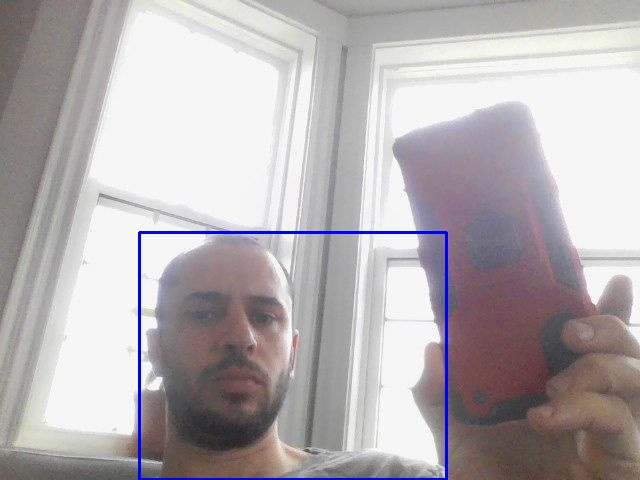

In [13]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
